In [1]:
import sympy as sym
from sympy import Matrix, MatrixSymbol, Symbol, tanh

**Содержание**<a id='toc0_'></a>    
- [__Backpropagation: одномерный случай__](#toc1_1_1_)    
- [__Backpropagation: общий случай__](#toc1_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
### <a id='toc1_1_1_'></a>[__Backpropagation: одномерный случай__](#toc0_)

* При __прямом__ проходе вычисляются и запоминаются состояния нейронов.
    
* При __обратном__ проходе ошибка, которую дала функция потерь, распространяется на слои от последнего к первому:
    1. Вычисляются значения частных производных функции потерь по весам нейросети - в точках, вычисленных при прямом проходе.
    2. Вычисляются и запоминаются значения прямых частных производных функции потерь по состояниям нейронов. Это понадобится при обработке следующего с конца слоя.
    3. Делается шаг градиентного спуска - обновляются веса нейросети.

22/02/2023
<br>Отвлекитесь от индексов, посмотрим на суть, на механику происходящего. Мы имеем матрешку - структуру многократно вложенных функций. Дифференцированная, эта структура раскладывается в длинную цепочку множителей, и дифференцирование, как природа происхождения этой цепочки, предоставляет нам интерфейс для работы с ней. В нашем API два принципиальных метода: "скрести по сусекам" и "лепить колобка". Скрести по сусекам можно двумя зеркальными способами: по весу - и тогда нейрон константа, по нейрону - и тогда вес константа. Дифференцируя по весам, мы подмешиваем в тесто нейроны, посчитанные при прямом проходе. Дифференцируя по нейронам, мы подмешиваем в тесто старые веса - "на потом", чтобы мы могли снова поскрести по весам на следующем шаге. В собранное же при дифференцировании по весу добавляются дрожжи лямбда learning rate - и этот слепленный колобок, выпеченный, отправляется на прогулку - обновлять веса для следующего поколения читателей этой сказки.

__Задача__. Воспользуйтесь цепным правилом, чтобы найти производную функции $(\cos e^x)^3$ в точке $x_0 = 0$.

$\underbrace{3g^2}_{h^{'}_{g}} \cdot \underbrace{(-\sin f)}_{g^{'}_{f}} \cdot \underbrace{e^x}_{f^{'}_{x}} = 3 \cdot (\cos e^x)^2 \cdot (-\sin e^x) \cdot e^x$

In [2]:
x = Symbol('x')
x0 = 0
f = sym.exp(x)
g = sym.cos(f)
h = g**3

deriv = sym.diff(h, x)
deriv

-3*exp(x)*sin(exp(x))*cos(exp(x))**2

In [3]:
deriv.subs(x, x0).evalf(3)

-0.737

In [4]:
round(sym.lambdify(x, deriv)(x0), 3)

-0.737

__Задача__. Найти частную производную среднеквадратичной функции потерь по весу последнего слоя.

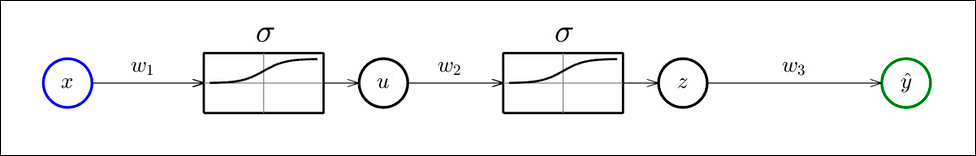

In [5]:
w1, w2, w3, x, ytrue = sym.symbols('w_1 w_2 w_3 x y_true')
params = {w1: 1, w2: 2, w3: 3, x: 10, ytrue: -1}

expit = lambda x: 1 / (1 + sym.exp(-x))
u = expit(w1 * x)
z = expit(w2 * u)
y = w3 * z

L = (y - ytrue)**2
sym.diff(L, w3).subs(params).round(1)

6.4

__Задача__. Сделать шаг backpropagation - обновить веса нейронной сети.

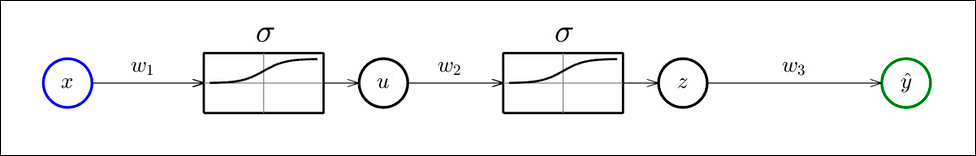

In [6]:
lrate, w1, w2, w3, x, ytrue = sym.symbols('lambda w_1 w_2 w_3 x y_true')
params = {lrate: .1, w1: 1, w2: 2, w3: 3, x: 10, ytrue: -1}

expit = lambda x: 1 / (1 + sym.exp(-x))
u = expit(w1 * x)
z = expit(w2 * u)
y = w3 * z
L = (y - ytrue)**2

[(w - lrate * sym.diff(L, w)).subs(params).round(3) for w in (w1, w2, w3)]

[1.00000000000000, 1.771, 2.358]

__Задача__. Сделать шаг backpropagation - обновить веса нейронной сети.

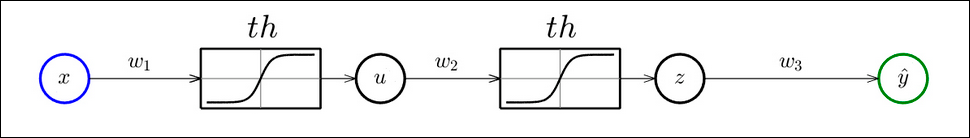

In [7]:
lrate, w1, w2, w3, x, ytrue = sym.symbols('lambda w_1 w_2 w_3 x y_true')
params = {lrate: .1, w1: 1, w2: -1, w3: 2, x: 5, ytrue: 7}

u = tanh(w1 * x)
z = tanh(w2 * u)
y = w3 * z
L = (y - ytrue)**2

[(w - lrate * sym.diff(L, w)).subs(params).round(3) for w in (w1, w2, w3)]

[0.999, 0.432, 0.702]

***
### <a id='toc1_1_2_'></a>[__Backpropagation: общий случай__](#toc0_)

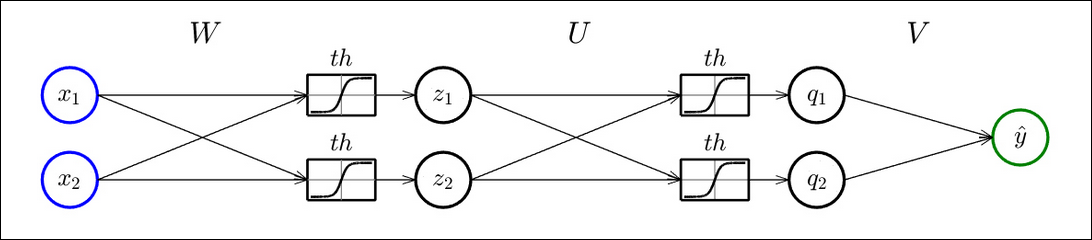

In [8]:
W = MatrixSymbol('W', 2, 2)
U = MatrixSymbol('U', 2, 2)
V = MatrixSymbol('V', 2, 1)
x = MatrixSymbol('x', 2, 1)
ytrue = MatrixSymbol('y_true', 1, 1)
lrate = Symbol('lambda')

params = {
    W: Matrix([[-1, 1], [1, 1]]),
    U: Matrix([[2, -4], [-.5, 1]]),
    V: Matrix([1, -1]),
    x: Matrix([1, 2]),
    ytrue: Matrix([5]),
    lrate: .1
}

z = (W.T @ x).applyfunc(tanh)
q = (U.T @ z).applyfunc(tanh)
y = V.T @ q
L = Matrix((y - ytrue)**2)

In [9]:
def updateWeights(W):
    # jacobian method demands W to be 
    # a string or a column matrix
    flat = False
    if 1 not in W.shape:
        r, c = W.shape
        W = Matrix(W).reshape(r*c, 1)
        flat = True
    W = ((W.T - lrate * L.jacobian(W))
         .subs(params).doit().evalf())
    if flat:  # back to original shape
        W = W.reshape(r, c)
    return W

In [10]:
updateWeights(V)

Matrix([[1.50350507682394, -1.63086604219443]])

In [11]:
updateWeights(U)

Matrix([
[   2.2005155627479, -4.03177487680557],
[-0.238017995095986, 0.958484788826255]])

[__jacobian: X can be a row or a column matrix__](https://docs.sympy.org/latest/modules/matrices/matrices.html?highlight=jacobian#sympy.matrices.matrices.MatrixCalculus.jacobian)

__Задача__. Найти градиент функции в заданной точке.

In [12]:
w, x, y, z = varbs = sym.symbols('w x y z')
point = .5, 2, 3, 4
d = dict(zip(varbs, point))
f = 1/w - w*x**2 + w*x*y
beautify = lambda n: int(n) if not n % 1 else float(n)

tuple(beautify(sym.diff(f, var).subs(d)) for var in varbs)

(-2, -0.5, 1, 0)

__Задача__. $f(x) = f(x_1,x_2) = (x^2_1,\,3x^2_1 - x_2,\,x_1x_2)$. Найти матрицу Якоби в заданной точке.

In [13]:
x, y  = varbs = sym.symbols('x y')
point = 1, 2
d = dict(zip(varbs, point))
funcs = x**2, 3*x**2 - y, x*y

Matrix([[sym.diff(f, var).subs(d) for var in varbs] for f in funcs])

Matrix([
[2,  0],
[6, -1],
[2,  1]])